<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#load-data" data-toc-modified-id="load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data</a></span><ul class="toc-item"><li><span><a href="#prepare-price-data" data-toc-modified-id="prepare-price-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>prepare price data</a></span></li><li><span><a href="#prepare-chat-data" data-toc-modified-id="prepare-chat-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>prepare chat data</a></span><ul class="toc-item"><li><span><a href="#load-fasttext-vectors" data-toc-modified-id="load-fasttext-vectors-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>load fasttext vectors</a></span></li><li><span><a href="#prepare-data-for-buy-model" data-toc-modified-id="prepare-data-for-buy-model-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>prepare data for buy model</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import pandas as pd

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# load data

In [2]:
# df_chats = pd.read_csv('../data/train/chats_train.csv')
df_chats = pd.read_csv('../data/clean_text.csv')
df_prices = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

## prepare price data

In [3]:
TICKER = 'ETH'
df_prices = df_prices[df_prices['ticker'] == TICKER].copy()

In [4]:
df_prices.head(2)

,datetime,name,priceBtc,priceUsd,ticker,volume
0,2018-03-01T00:00:00Z,Ethereum,0.082836,856.952292,ETH,1.979010e+09
1,2018-03-01T02:00:00Z,Ethereum,0.082887,858.979167,ETH,1.931840e+09


In [5]:
df_prices['delta_price_usd'] = (df_prices['priceUsd'] - df_prices['priceUsd'].shift(1)) / df_prices['priceUsd'].shift(1)

In [6]:
df_prices['delta_price_usd'].fillna(0, inplace=True)

In [7]:
quantile1 = df_prices['delta_price_usd'].quantile(q=0.33)
quantile2 = df_prices['delta_price_usd'].quantile(q=0.66)

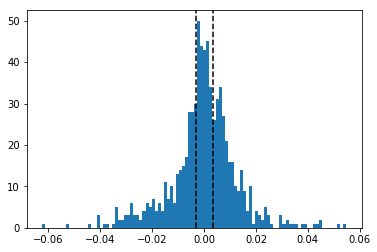

In [8]:
plt.hist(df_prices['delta_price_usd'], bins=100)
plt.axvline(quantile1, color='k', linestyle='dashed')
plt.axvline(quantile2, color='k', linestyle='dashed')
plt.show()

In [9]:
print(
    df_prices[df_prices['delta_price_usd'] < quantile1].shape,
    df_prices[df_prices['delta_price_usd'] > quantile2].shape,
    df_prices[(df_prices['delta_price_usd'] > quantile1) & (df_prices['delta_price_usd'] < quantile2)].shape,
)

(242, 7) (249, 7) (241, 7)


In [10]:
df_prices['timestamp'] = pd.to_datetime(df_prices['datetime']).apply(lambda x: x.timestamp())

In [11]:
df_prices.head()

,datetime,name,priceBtc,priceUsd,ticker,volume,delta_price_usd,timestamp
0,2018-03-01T00:00:00Z,Ethereum,0.082836,856.952292,ETH,1.979010e+09,0.000000,1.519862e+09
1,2018-03-01T02:00:00Z,Ethereum,0.082887,858.979167,ETH,1.931840e+09,0.002365,1.519870e+09
2,2018-03-01T04:00:00Z,Ethereum,0.082744,861.494542,ETH,1.908910e+09,0.002928,1.519877e+09
3,2018-03-01T06:00:00Z,Ethereum,0.082734,862.998542,ETH,1.866320e+09,0.001746,1.519884e+09
4,2018-03-01T08:00:00Z,Ethereum,0.081945,869.481042,ETH,1.834750e+09,0.007512,1.519891e+09


## prepare chat data

In [12]:
df_chats.head()

,chat_id,chat_title,emoji_list,sender_first_name,sender_id,sender_is_bot,sender_last_name,sender_username,text,timestamp,clean_text,words_count,repeats,has_digit
0,1129149026,Pareto Network - Discussion,[],Bezant,526106862,False,None,None,admin disputes in private thank you.,1524284160,admin disputes in private thank you,6,1,False
1,1129149026,Pareto Network - Discussion,[],Sheriff,538526216,False,None,None,i see binance add coins all the time on the cr...,1524284160,i see binance add coins all the time on the cr...,29,1,False
2,1129149026,Pareto Network - Discussion,[],Sheriff,538526216,False,None,None,shouldn’t it go up with btc though?,1524285978,shouldn t it go up with btc though,8,1,False
3,1146170349,Binance English,[],Vijay,494914527,False,Singh,None,no i wanna fuck you hard.,1524287086,no i wanna fuck you hard,6,1,False
4,1146170349,Binance English,[],A5,548628461,False,None,None,speak english you fukin immigrant . lol you geek,1524286965,speak english you fukin immigrant lol you geek,8,1,False


In [13]:
df_chats.shape, df_chats[df_chats['clean_text'].str.contains('eth')].shape

((933800, 14), (29788, 14))

In [14]:
df_chats = df_chats[df_chats['clean_text'].str.contains('eth')].copy()

In [15]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [16]:
PERIOD = 8*3600

news_counts = []
for i, row in df_prices.iterrows():
    ts = row['timestamp']
    c = df_chats[(df_chats['timestamp'] < ts) & (df_chats['timestamp'] > ts - PERIOD)].shape[0]
    news_counts.append(c)

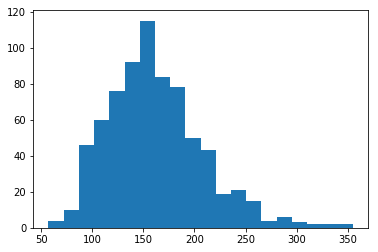

In [17]:
plt.hist(news_counts, bins=20)
plt.show()

In [18]:
chat_ids = list(df_chats['chat_id'].unique())
chat_ids.sort()
chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}

sender_ids = list(df_chats['sender_id'].unique())
sender_ids.sort()
sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}

In [19]:
df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])

In [20]:
len(chat2ind), len(sender2ind)

(45, 10591)

### load fasttext vectors

In [21]:
vectors = np.load('../data/chat_vectors_100.npy')

### prepare data for buy model

In [106]:
inp_fasttext = []
inp_chat_ind = []
inp_sender_ind = []
inp_timedelta_log = []
out_target = [] # grow more than 0.66 quantile, not drawdown less 0.33 quantile in period 48 hours

In [107]:
TARGET_MIN_UP = 1.1
TARGET_MAX_DOWN = 0.95
SAMPLES = 5
STEPS = 32

for i, row in df_prices.iterrows():
    for sample in range(SAMPLES):
        ts = row['timestamp']

        df_chats_sample = df_chats[(df_chats['timestamp'] > ts - 48 * 3600) & (df_chats['timestamp'] < ts)].sample(STEPS)
        df_chats_sample['timedelta'] = np.log(-(df_chats_sample['timestamp'] - ts))

        chat_indexes = df_chats_sample['ind'].values

        batch_fasttext = vectors[chat_indexes]
#         batch_sender_bot = df_chats.iloc[chat_indexes]['sender_is_bot'].values
        batch_chat_ind = df_chats.iloc[chat_indexes]['chat_ind'].values
        batch_sender_ind = df_chats.iloc[chat_indexes]['sender_ind'].values
        batch_timedelta = df_chats_sample['timedelta'].values

        df_prices_forward = df_prices[(df_prices['timestamp'] > ts) & (df_prices['timestamp'] <= ts + 48 * 3600)].copy()
#         print(df_prices_forward.shape)
        
        if df_prices_forward.shape[0] < 24:
            continue
        df_prices_forward['priceUsd'] /= df_prices_forward['priceUsd'].values[0]

        target = False
        for price_relative in df_prices_forward['priceUsd'].values:
            if price_relative < TARGET_MAX_DOWN:
                target = False
                break
            if price_relative > TARGET_MIN_UP:
                target = True
                break

        inp_fasttext.append(batch_fasttext)
#         inp_sender_bot.append(batch_sender_bot)
        inp_chat_ind.append(batch_chat_ind)
        inp_sender_ind.append(batch_sender_ind)
        inp_timedelta_log.append(batch_timedelta)
        out_target.append(target)

In [108]:
inp_fasttext = np.array(inp_fasttext)
# inp_sender_bot = np.array(inp_sender_bot)
inp_chat_ind = np.array(inp_chat_ind)
inp_sender_ind = np.array(inp_sender_ind)
inp_timedelta_log = np.array(inp_timedelta_log)

out_target = np.array(out_target)

In [109]:
out_target.shape

(3540,)

In [110]:
# inp_sender_bot = np.expand_dims(inp_sender_bot, 2)

In [111]:
inp_chat_ind = np.expand_dims(inp_chat_ind, 2)
inp_sender_ind = np.expand_dims(inp_sender_ind, 2)
inp_timedelta_log = np.expand_dims(inp_timedelta_log, 2)

In [155]:
SENDER_EMBEDDING_SIZE = 128
CHAT_EMBEDDING_SIZE = 4

inp_layer_fasttext = Input(shape=(STEPS, 100, ), name='inp_layer_fasttext')
# inp_layer_sender_bot = Input(shape=(STEPS, 1, ), name='inp_layer_sender_bot')
inp_layer_chat = Input(shape=(STEPS, 1, ), name='inp_layer_chat')
inp_layer_sender = Input(shape=(STEPS, 1, ), name='inp_layer_sender')
inp_layer_timedelta = Input(shape=(STEPS, 1, ), name='inp_layer_timedelta')

sender_embedding = Embedding(len(sender2ind), SENDER_EMBEDDING_SIZE)(inp_layer_sender)
chat_embedding = Embedding(len(chat2ind), CHAT_EMBEDDING_SIZE)(inp_layer_chat)

sender_embedding = Reshape((STEPS, SENDER_EMBEDDING_SIZE))(sender_embedding)
chat_embedding = Reshape((STEPS, CHAT_EMBEDDING_SIZE))(chat_embedding)

common_layer = Concatenate(axis=-1)([
    inp_layer_fasttext, chat_embedding, sender_embedding, inp_layer_timedelta])

lstm = LSTM(8)(common_layer)
# lstm = LSTM(8)(lstm)

dense = Dense(1, activation='sigmoid')(lstm)

model = Model(
    inputs=[inp_layer_fasttext, inp_layer_chat, inp_layer_sender, inp_layer_timedelta],
    outputs=dense
)

opt = Adam(lr=0.0002)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='binary_crossentropy')

In [156]:
test_size = int(inp_fasttext.shape[0] * 0.1)

In [ ]:
model.fit(
    [inp_fasttext[:-test_size], inp_chat_ind[:-test_size], inp_sender_ind[:-test_size], inp_timedelta_log[:-test_size]],
    out_target[:-test_size],
    validation_data=[
        [inp_fasttext[-test_size:], inp_chat_ind[-test_size:], inp_sender_ind[-test_size:], inp_timedelta_log[-test_size:]],
        out_target[-test_size:]
    ],
    class_weight=[0.15, 1],
    epochs=10
)

Train on 3186 samples, validate on 354 samples
Epoch 1/10
3186/3186 [==============================] - 8s 2ms/step - loss: 0.4239 - acc: 0.8807 - val_loss: 0.3493 - val_acc: 0.8898
Epoch 2/10
3186/3186 [==============================] - 5s 2ms/step - loss: 0.3626 - acc: 0.8836 - val_loss: 0.3438 - val_acc: 0.8898
Epoch 3/10
3186/3186 [==============================] - 6s 2ms/step - loss: 0.3533 - acc: 0.8836 - val_loss: 0.3441 - val_acc: 0.8898
Epoch 4/10
3186/3186 [==============================] - 6s 2ms/step - loss: 0.3271 - acc: 0.8836 - val_loss: 0.3389 - val_acc: 0.8898
Epoch 5/10
3186/3186 [==============================] - 6s 2ms/step - loss: 0.2827 - acc: 0.8836 - val_loss: 0.3413 - val_acc: 0.8898
Epoch 6/10
 448/3186 [===>..........................] - ETA: 4s - loss: 0.2349 - acc: 0.8929

In [139]:
out_target.shape, sum(out_target)

((3540,), 410)

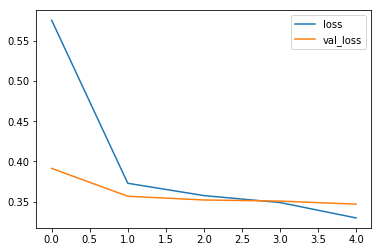

In [140]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

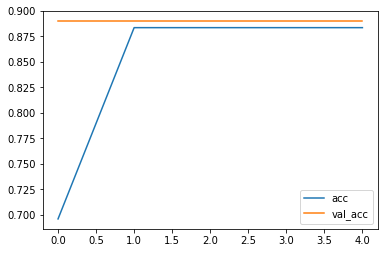

In [141]:
plt.plot(model.history.history['acc'], label='acc')
plt.plot(model.history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [142]:
y_test_predict = model.predict([
    inp_fasttext[-test_size:], inp_chat_ind[-test_size:], 
    inp_sender_ind[-test_size:], inp_timedelta_log[-test_size:]])

In [143]:
roc_auc_score(out_target[-test_size:], y_test_predict[:, 0])

0.561986161986162

In [144]:
fpr, tpr, _ = roc_curve(out_target[-test_size:], y_test_predict[:, 0])

[]

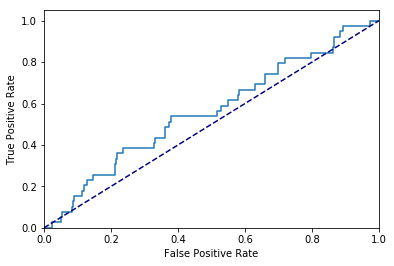

In [145]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()

In [125]:
model.save('../data/model_quantile_chats.pkl')